In [1]:
import os
import glob
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point

In [2]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username
dbname = 'map_the_vote'
username = 'codyschank' # change this to your username

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://codyschank@localhost/map_the_vote
True


In [14]:
path = '/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/'
extension = 'csv'
os.chdir(path)
files = [i for i in glob.glob('*.{}'.format(extension))]
files = [path + s for s in files]

In [17]:
# FIRST do the first file
address_data = pd.read_csv(files[0], dtype={"LON": float, "LAT": float, "NUMBER": str, "STREET": str, "UNIT": str, 
                            "CITY": str, "DISTRICT": str, "REGION": str, "POSTCODE": str, "ID": str,
                            "HASH": str}, keep_default_na=False)
# combine text LON and LAT fields into a geometry 
geometry = [Point(xy) for xy in zip(address_data.LON, address_data.LAT)]
address_data_gd = gpd.GeoDataFrame(address_data, crs=4326, geometry=geometry)

# convert column names to lower case will help later with database queries
address_data_gd.columns = map(str.lower, address_data_gd.columns)

address_data_gd["street_address"] = address_data_gd["number"].map(str) + ' ' +  address_data_gd["street"]

# this is a bit slow, takes about 30-60s
# I don't know why this is necessary, but it is 
address_data_gd['geom'] = address_data_gd['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
address_data_gd.drop('geometry', 1, inplace=True)

In [18]:
table_name = "addresses_table_tx"
#had to run this from command line first: psql map_the_vote -c "CREATE EXTENSION postgis";
#write first 1000 rows to database
address_data_gd.head(1000).to_sql(table_name, engine, if_exists='replace', index=False, 
                                dtype={'geom': Geometry('POINT', srid= 4326)})

In [19]:
chunk_size = 1000
for i in range(1000, address_data_gd.shape[0]+chunk_size, chunk_size):
    address_data_gd[i:(i+chunk_size)].to_sql(table_name, engine, if_exists='append', index=False, 
                                dtype={'geom': Geometry('POINT', srid= 4326)})

In [24]:
# NOW do the rest of the files
for file in files[1:]: # skip the first one since I read it in already
    print(file)
    address_data = pd.read_csv(file, dtype={"LON": float, "LAT": float, "NUMBER": str, "STREET": str, "UNIT": str, 
                                "CITY": str, "DISTRICT": str, "REGION": str, "POSTCODE": str, "ID": str,
                                "HASH": str}, keep_default_na=False)

    # combine text LON and LAT fields into a geometry 
    geometry = [Point(xy) for xy in zip(address_data.LON, address_data.LAT)]
    address_data_gd = gpd.GeoDataFrame(address_data, crs=4326, geometry=geometry)

    # convert column names to lower case will help later with database queries
    address_data_gd.columns = map(str.lower, address_data_gd.columns)
    
    address_data_gd["street_address"] = address_data_gd["number"].map(str) + ' ' +  address_data_gd["street"]
    
    # this is a bit slow, takes about 30-60s
    # I don't know why this is necessary, but it is 
    address_data_gd['geom'] = address_data_gd['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
    address_data_gd.drop('geometry', 1, inplace=True)
    for i in range(0, address_data_gd.shape[0]+chunk_size, chunk_size):
        address_data_gd[i:(i+chunk_size)].to_sql(table_name, engine, if_exists='append', index=False, 
                                                    dtype={'geom': Geometry('POINT', srid= 4326)})
    

/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/colleyville.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/city_of_garland.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/schleicher.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/coryell.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/city_of_sugar_land.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/tarrant-county.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/texoma-counties.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/fayette.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/city_of_cedar_park.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/grimes.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/brazos.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/city_of_killeen.csv
/Users/codyschank/Downloads/openaddr-collected-us_sout

/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/houston.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/hidalgo_county.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/greater_houston.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/hansford.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/titus.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/bastrop.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/trinity.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/round_rock.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/bandera.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/washington.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/fannin.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/gaines.csv
/Users/codyschank/Downloads/openaddr-collected-us_south/us/tx/gray.csv
/Users/codyschank/Downl

In [3]:
con = None
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT * FROM addresses_table_tx;
"""
addresses_table_from_sql = pd.read_sql_query(sql_query,con)
addresses_table_from_sql.head()


,lon,lat,number,street,unit,city,district,region,postcode,id,hash,street_address,geom
0,-95.112886,29.702757,1101,ALAN ST,,,,,77536,,ddb623e650215138,1101 ALAN ST,0101000020E610000012EB9E8639C757C0A70AA1DEE7B3...
1,-95.434048,29.891352,2006,BUNZEL ST,,,,,77088,,12042a9a78bf077c,2006 BUNZEL ST,0101000020E6100000D0F81972C7DB57C0BE3C539E2FE4...
2,-95.424612,29.889554,1430,PEACH SPRING DR,,,,,77088,,ee803fb17bbe5dc7,1430 PEACH SPRING DR,0101000020E6100000E31EA6D82CDB57C0D78A36C7B9E3...
3,-95.774673,29.774074,518,MARBLE HILL DR,,,,,77450,,f8f3699aeb999fb3,518 MARBLE HILL DR,0101000020E61000003DA6A43D94F157C0C1B057B329C6...
4,-95.426028,29.892080,9014,RUTHERFORD LN,,,,,77088,,c320f2e1d6caafe6,9014 RUTHERFORD LN,0101000020E6100000C06B860A44DB57C040EB2B595FE4...


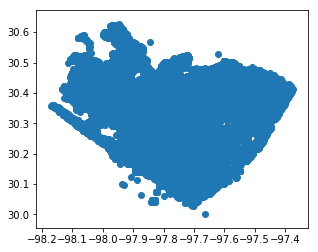

In [10]:
# read back in a way that returns the geometry in a geopandas object.
# addresses_table_from_sql_gd = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')
# addresses_table_from_sql_gd.plot()
# plt.show()
